In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from PIL import Image
from tqdm import tqdm
from scipy.signal import correlate2d
import cv2
from scipy import ndimage, datasets
import time
from scipy.interpolate import griddata

np.set_printoptions(precision=2)

In [129]:
PATCH_SIZE = 5
HALF_SIZE = PATCH_SIZE // 2

PATCH_REGION = lambda i, j : (slice(i - HALF_SIZE, i + HALF_SIZE + 1), \
                              slice(j - HALF_SIZE, j + HALF_SIZE + 1))

# SAFE_PATCH_REGION = lambda i, j, h, w : (slice(max(0, i - HALF_SIZE), min(h, i + HALF_SIZE + 1)), \
#                                          slice(max(0, j - HALF_SIZE), min(w, j + HALF_SIZE + 1)))

def SAFE_PATCH_REGION(i, j, h, w, halflen=HALF_SIZE, cutoff_edges=False):
    minval = HALF_SIZE if cutoff_edges else 0

    return slice(max(minval, i - halflen), min(h - minval, i + halflen + 1)), \
           slice(max(minval, j - halflen), min(w - minval, j + halflen + 1))


def REGION_INTERSECT(ij1, r1, ij2, r2):
    # For region 1
    i1, j1 = ij1
    i2, j2 = ij2

    r1_y0, r1_x0, r1_y1, r1_x1 = r1[0].start, r1[1].start, r1[0].stop, r1[1].stop
    r2_y0, r2_x0, r2_y1, r2_x1 = r2[0].start, r2[1].start, r2[0].stop, r2[1].stop

    top = min(i1 - r1_y0, i2 - r2_y0)
    bottom = min(r1_y1 - i1, r2_y1 - i2)
    right = min(r1_x1 - j1, r2_x1 - j2)
    left = min(j1 - r1_x0, j2 - r2_x0)

    region1 = (slice(i1 - top, i1 + bottom), slice(j1 - left, j1 + right))
    region2 = (slice(i2 - top, i2 + bottom), slice(j2 - left, j2 + right))

    return region1, region2
    

MASK_COLOR = [0, 255, 0]

N_PATCH_MATCH_ITERS = 20

In [130]:
# image = np.ones((512, 512, 3), dtype=np.int64) * 200
# mask = np.zeros((512, 512), dtype=bool)

# for r in range(image.shape[0]):
#     for c in range(image.shape[1]):
#         if 512-30 <= (r + c) <= 512+30:
#             image[r, c] = 0

#         if (r - 256) ** 2 + (c - 256) ** 2 <= 64 ** 2:
#             mask[r, c] = 1

4 Pyramid Levels


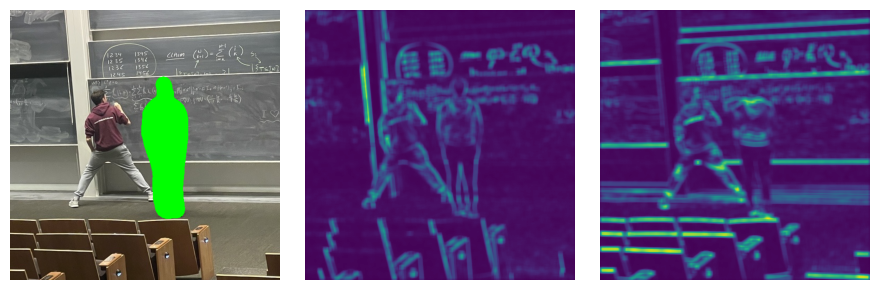

In [222]:
def in_bounds(r, c, h, w, dilated=False):
    starter = HALF_SIZE if dilated else 0
    return (r >= starter and r < h - starter) and (c >= starter and c < w - starter)
    
def masked_image(img, mask):
    return ~mask[:, :, np.newaxis] * img + (mask[:, :, np.newaxis]) * MASK_COLOR

image = Image.open('menmax.jpg')
image = np.array(image)

mask = Image.open('menmax-mask.jpg')
mask = np.mean(np.array(mask), axis=-1)
mask = mask < 128

height, width, channels = image.shape

count_erosions_mask = mask.copy()
N_o = 0

while count_erosions_mask.any():
    erosion = ndimage.binary_erosion(count_erosions_mask, structure=np.ones((3, 3)))
    boundary = count_erosions_mask ^ erosion

    N_o += 1

    count_erosions_mask = erosion

n_pyramid_levels = 4 #np.ceil( np.log2(2 * N_o / (PATCH_SIZE * PATCH_SIZE)) ).astype(int)
print(f"{n_pyramid_levels} Pyramid Levels")

grey_image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
gradient_y, gradient_x = np.abs(np.gradient(grey_image.astype(float)))
gradient = np.stack([gradient_x, gradient_y], axis=-1)

# gradient_norm = np.linalg.norm(gradient, axis=-1, keepdims=True)
# gradient = gradient / gradient_norm


patch_counts = np.zeros_like(grey_image, dtype=int)

texture = np.empty(shape=(height, width, 2))

for i in range(height):
    for j in range(width):
        sidelen = 1 + 2 ** (n_pyramid_levels - 1)
        texture_region = SAFE_PATCH_REGION(i, j, height, width, halflen=sidelen//2)
        
        cardinality = sidelen * sidelen

        texture[i, j, 0] = 1/cardinality * np.sum(gradient[texture_region][..., 0])
        texture[i, j, 1] = 1/cardinality * np.sum(gradient[texture_region][..., 1])


# texture /= 255.0

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(masked_image(image, mask))
axs[0].axis('off')

axs[1].imshow(texture[...,0])
axs[1].axis('off')

axs[2].imshow(texture[...,1])
axs[2].axis('off')

plt.tight_layout()
plt.show()

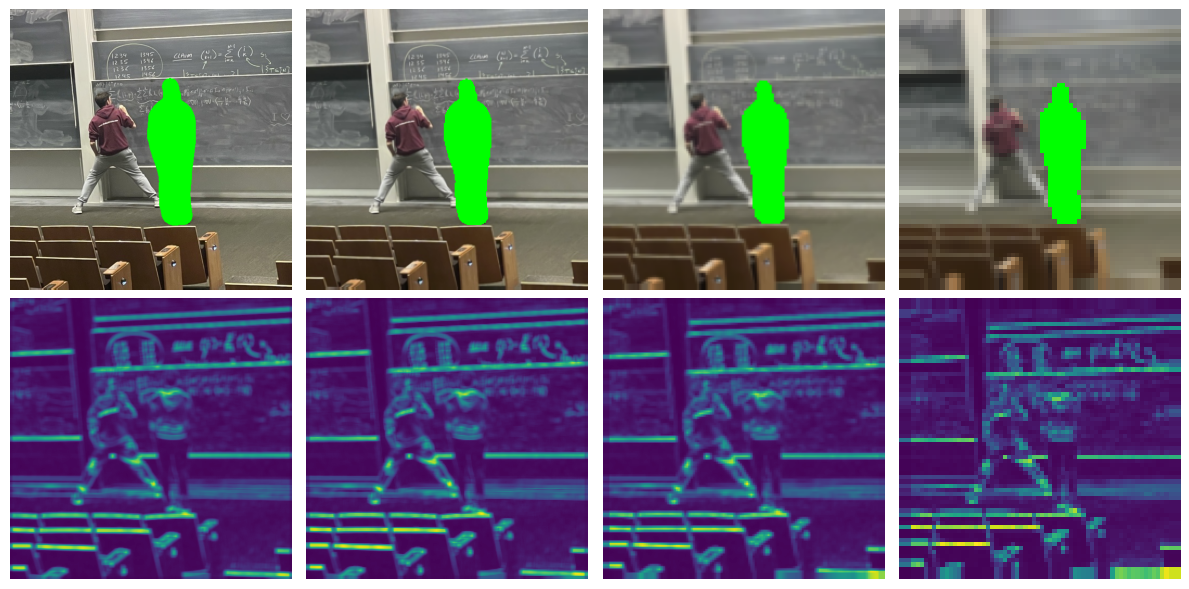

In [223]:
image_pyramid = [image.copy()]
texture_pyramid = [texture.copy()]
mask_pyramid = [mask.copy()]

for i in range(1, n_pyramid_levels):
    # Apply Gaussian 3x3 kernel and downsample image
    next_level_image = ndimage.gaussian_filter(image_pyramid[-1], sigma=(1, 1, 0))[::2, ::2]
    image_pyramid.append(next_level_image)

    # Downsample texture map
    multiplier = 2 ** i
    next_level_texture = texture_pyramid[0][::multiplier, ::multiplier]
    texture_pyramid.append(next_level_texture)

    # Downsample the mask using (2x2) max pooling 
    # next_level_mask = ndimage.maximum_filter(mask_pyramid[-1], size=(2, 2))[::2, ::2]
    next_level_mask = mask_pyramid[-1][::2, ::2]
    mask_pyramid.append(next_level_mask)

padding_width = [(HALF_SIZE, HALF_SIZE), (HALF_SIZE, HALF_SIZE), (0, 0)]

for i in range(0, n_pyramid_levels):
    image_pyramid[i] = np.pad(image_pyramid[i], pad_width=padding_width, mode='edge')
    texture_pyramid[i] = np.pad(texture_pyramid[i], pad_width=padding_width, mode='edge')
    mask_pyramid[i] = np.pad(mask_pyramid[i], pad_width=padding_width[:-1], mode='edge') # TODO: fix this to be constant?

fig, axs = plt.subplots(2, len(image_pyramid), figsize=(12, 6))
for i, (img, msk) in enumerate(zip(image_pyramid, mask_pyramid)):
    axs[0, i].imshow(masked_image(img, msk))
    axs[0, i].axis('off')

    axs[1, i].imshow(texture_pyramid[i][..., 1])
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


In [242]:
rho = 0.5
lam = 50
    
def partial_dist(image, texture, mask, patch_center_A, patch_center_B):
    image_h, image_w, _ = image.shape

    i_A, j_A = patch_center_A
    i_B, j_B = patch_center_B

    region_A = PATCH_REGION(i_A, j_A) #, image_h, image_w)
    region_B = PATCH_REGION(i_B, j_B) #, image_h, image_w)

    region_A_mask = mask[region_A][:, :, np.newaxis]

    region_A_image = image[region_A]
    region_A_texture = texture[region_A]

    region_B_image = image[region_B]
    region_B_texture = texture[region_B]

    partial_patch_area = np.sum((~region_A_mask).astype(int))

    masked_region_A_image = region_A_image * ~region_A_mask
    masked_region_A_texture = region_A_texture * ~region_A_mask

    masked_region_B_image = region_B_image * ~region_A_mask
    masked_region_B_texture = region_B_texture * ~region_A_mask
    
    ssd_image = np.sum(np.square(masked_region_A_image - masked_region_B_image))
    ssd_texture = np.sum(np.square(masked_region_A_texture - masked_region_B_texture))

    return 1/partial_patch_area * (ssd_image + lam * ssd_texture)

def dist(image, texture, mask, patch_center_A, patch_center_B):
    image_h, image_w, _ = image.shape

    i_A, j_A = patch_center_A
    i_B, j_B = patch_center_B

    region_A = PATCH_REGION(i_A, j_A) #, image_h, image_w)
    region_B = PATCH_REGION(i_B, j_B) #, image_h, image_w)

    region_A_image = image[region_A]
    region_A_texture = texture[region_A]

    region_B_image = image[region_B]
    region_B_texture = texture[region_B]

    patch_area = PATCH_SIZE * PATCH_SIZE
    
    try:
        ssd_image = np.sum(np.square(region_A_image - region_B_image))
        ssd_texture = np.sum(np.square(region_A_texture - region_B_texture))
    except:
        print(region_A.start, region_A.stop)
        print(region_B.start, region_B.stop)

    return 1/patch_area * (ssd_image + lam * ssd_texture)

def ann(image, texture, mask, shift_map, init=False, boundary_mask=None, shrinking_mask=None):
    dist_fn = dist if not init else partial_dist

    image_h, image_w, image_c = image.shape
    max_dimension = max(image_h, image_w)

    structure_element = np.ones((PATCH_SIZE, PATCH_SIZE))

    dilated_mask = ndimage.binary_dilation(mask, structure=structure_element)

    offsets = {
        0: [np.array([0, 0], dtype=int), np.array([-1, 0], dtype=int), np.array([0, -1], dtype=int)],
        1: [np.array([0, 0], dtype=int), np.array([1, 0], dtype=int), np.array([0, 1], dtype=int)]
    }

    image_indices = {
        0: ([HALF_SIZE, image_h - HALF_SIZE, 1], [HALF_SIZE, image_w - HALF_SIZE, 1]),
        1: ([image_h - HALF_SIZE - 1, HALF_SIZE - 1, -1], [image_w - HALF_SIZE - 1, HALF_SIZE - 1, -1]),
    }

    distance_map = np.zeros(shape=(image_h, image_w))
    
    # ANN Search
    for k in range(10):
        r_range, c_range = image_indices[k%2]
        coord_ox = offsets[k%2]

        for r in range(*r_range):
            for c in range(*c_range):
                if init and not boundary_mask[r, c]: continue
                elif not init and not dilated_mask[r, c]: continue

                # Propagation stage
                curr_coord = np.array([r, c])

                min_shift, min_dist = shift_map[r, c], dist_fn(image, texture, shrinking_mask, curr_coord, curr_coord + shift_map[r, c])
                
                for (shift_i, shift_j) in coord_ox:
                    correspondant_i, correspondant_j = r + shift_i, c + shift_j
                    
                    if not in_bounds(correspondant_i, correspondant_j, image_h, image_w, dilated=True): 
                        continue
                    
                    # candidate_shift_i, candidate_shift_j = shift_map[correspondant_i, correspondant_j]
                    candidate_i, candidate_j = curr_coord + shift_map[correspondant_i, correspondant_j]

                    if not in_bounds(candidate_i, candidate_j, image_h, image_w, dilated=True): 
                        continue

                    candidate_distance = dist_fn(image, texture, shrinking_mask, curr_coord, (candidate_i, candidate_j))

                    if not dilated_mask[candidate_i, candidate_j] and candidate_distance < min_dist:
                        # print(f"Accepting neighbor value for {r,c} from {correspondant_i, correspondant_j}")
                        min_dist = candidate_distance
                        min_shift = shift_map[correspondant_i, correspondant_j]

                shift_map[r, c] = min_shift
                distance_map[r, c] = min_dist

                
                # Random search stage
                # cov_mat = (max_dimension / 3) ** 2 * np.eye(2)
                # NN = int(np.log2(max_dimension))
                # for _ in range(NN):
                #     candidate_i, candidate_j = r, c

                #     while not in_bounds(candidate_i, candidate_j, image_h, image_w, dilated=True) or dilated_mask[candidate_i, candidate_j]:
                #         candidate_i, candidate_j = np.random.multivariate_normal(mean=[r, c], cov=cov_mat).astype(np.int64)

                #     candidate_dist = dist_fn(image, texture, shrinking_mask, curr_coord, (candidate_i, candidate_j))
                #     if candidate_distance < distance_map[r, c]:
                #         shift_map[r, c] = [candidate_i - r, candidate_j - c]
                #         distance_map[r, c] = candidate_dist

                alpha = 1.0
                original_shift = shift_map[r, c]

                while alpha * max_dimension >= 1:
                    rand_uniform = np.random.uniform(-1, 1, 2)

                    offset = np.floor(max_dimension * alpha * rand_uniform).astype(np.int64)
                    q_i, q_j = curr_coord + original_shift + offset

                    if in_bounds(q_i, q_j, image_h, image_w, dilated=True) and not dilated_mask[q_i, q_j]:
                        q_distance = dist_fn(image, texture, shrinking_mask, curr_coord, (q_i, q_j))

                        if q_distance < distance_map[r, c]:
                            shift_map[r, c] = original_shift + offset
                            distance_map[r, c] = q_distance

                        # q_shift = shift_map[q_i, q_j]
                        # candidate_coord = curr_coord + q_shift

                        # if in_bounds(*candidate_coord, image_h, image_w, dilated=True):
                        #     q_distance = dist_fn(image, texture, shrinking_mask, curr_coord, candidate_coord)

                        #     if not dilated_mask[candidate_coord[0], candidate_coord[1]] and q_distance < distance_map[r, c]:
                        #         shift_map[r, c] = q_shift
                        #         distance_map[r, c] = q_distance
                
                    alpha *= rho
                    
    return distance_map

def reconstruction(image, texture, mask, shift_map, distance_map, init=False, boundary_mask=None, shrinking_mask=None):
    if init: assert boundary_mask is not None

    image_h, image_w, image_c = image.shape

    for r in range(HALF_SIZE, image_h - HALF_SIZE, 1):
        for c in range(HALF_SIZE, image_w - HALF_SIZE, 1):
            if init and not boundary_mask[r, c]: continue
            elif not init and not mask[r, c]: continue

            neighborhood = SAFE_PATCH_REGION(r, c, image_h, image_w, cutoff_edges=True)
            neighborhood_distances = distance_map[neighborhood]
            neighborhood_shifts = shift_map[neighborhood]

            region_area = neighborhood_distances.shape[0] * neighborhood_distances.shape[1]

            q = 75
            if init:
                n_masked = np.sum(shrinking_mask[neighborhood])
                neighborhood_distances *= ~shrinking_mask[neighborhood]
                q = 100.0 * (n_masked + 0.75 * (region_area - n_masked)) / region_area

            sigma_p = max(1e-6, np.percentile(neighborhood_distances, q=q))
            
            scores = np.exp(-neighborhood_distances / (2 * sigma_p ** 2))
            if init:
                scores *= ~shrinking_mask[neighborhood]

            total_scores = np.sum(scores)

            pixels_with_shifts = np.array([r, c])[np.newaxis, np.newaxis, :] + neighborhood_shifts
            
            weighted_image_pixels = scores[:, :, np.newaxis] * image[pixels_with_shifts[..., 0], pixels_with_shifts[..., 1]]
            weighted_texture_pixels = scores[:, :, np.newaxis] * texture[pixels_with_shifts[..., 0], pixels_with_shifts[..., 1]]

            image_pixel = np.sum(weighted_image_pixels, axis=(0, 1)) / total_scores
            texture_pixel = np.sum(weighted_texture_pixels, axis=(0, 1)) / total_scores

            image[r, c] = image_pixel
            texture[r, c] = texture_pixel

def upsample_shift_map(shift_map):
    image_h, image_w, _ = shift_map.shape
    new_image_h, new_image_w = 2 * (image_h - 2 * HALF_SIZE) + 2 * HALF_SIZE, 2 * (image_w - 2 * HALF_SIZE) + 2 * HALF_SIZE

    upsampled_shift_map = np.empty(shape=(new_image_h, new_image_w, 2), dtype=np.int64)

    for r in range(HALF_SIZE, new_image_h - HALF_SIZE, 1):
        for c in range(HALF_SIZE, new_image_w - HALF_SIZE, 1):
            translated_r, translated_c = r - HALF_SIZE, c - HALF_SIZE
            downsampled_r, downsampled_c = translated_r // 2 + HALF_SIZE, translated_c // 2 + HALF_SIZE

            upsampled_shift_map[r, c] = 2 * shift_map[downsampled_r, downsampled_c]
    
    return upsampled_shift_map

def upsample_distance_map(upsampled_image, upsampled_texture, upsampled_mask, upsampled_shift_map):
    image_h, image_w, _ = upsampled_shift_map.shape
    upsampled_distance_map = np.zeros(shape=(image_h, image_w))

    for r in range(HALF_SIZE, image_h - HALF_SIZE, 1):
        for c in range(HALF_SIZE, image_w - HALF_SIZE, 1):
            curr_coord = np.array([r, c])
            upsampled_shift = upsampled_shift_map[r, c]

            upsampled_distance_map[r, c] = dist(upsampled_image, upsampled_texture, upsampled_mask,
                                                curr_coord, curr_coord + upsampled_shift)
    
    return upsampled_distance_map

def final_image_reconstruction(image, mask, shift_map, distance_map):
    image_h, image_w, _ = image.shape

    for r in range(HALF_SIZE, image_h - HALF_SIZE, 1):
        for c in range(HALF_SIZE, image_w - HALF_SIZE, 1):
            if not mask[r, c]: continue

            min_distance = distance_map[r, c]
            min_coord = (r, c)

            for rr in range(max(HALF_SIZE, r - HALF_SIZE), min(image_h - HALF_SIZE, r + HALF_SIZE)):
                for cc in range(max(HALF_SIZE, c - HALF_SIZE), min(image_w - HALF_SIZE, c + HALF_SIZE)):
                    if distance_map[rr, cc] < min_distance:
                        min_distance = distance_map[rr, cc]
                        min_coord = (rr, cc)
            
            correspondant_shift = shift_map[min_coord[0], min_coord[1]]
            image[r, c] = image[r + correspondant_shift[0], c + correspondant_shift[1]]


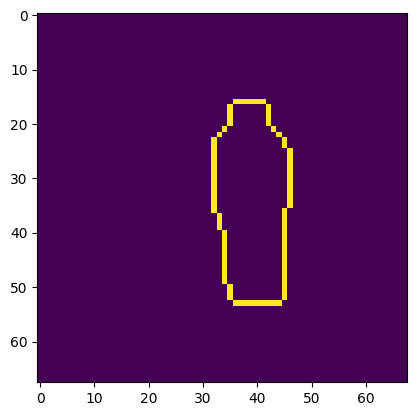

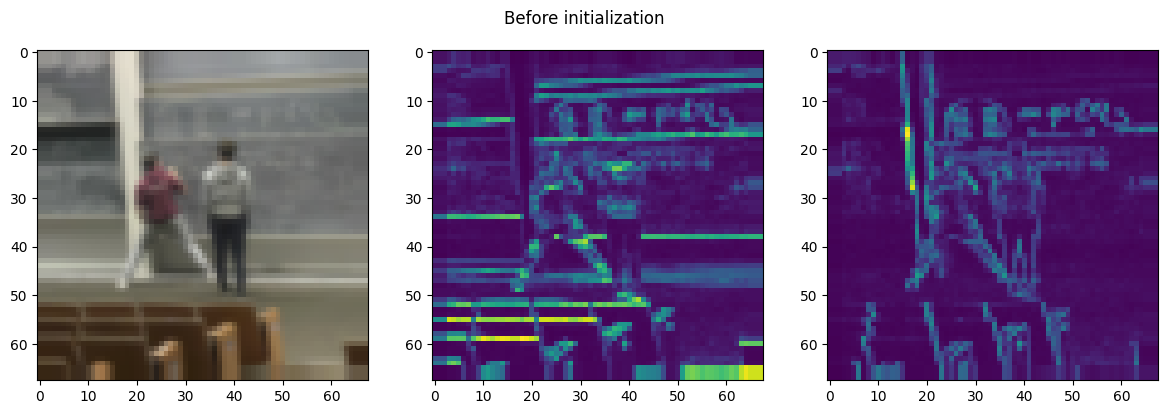

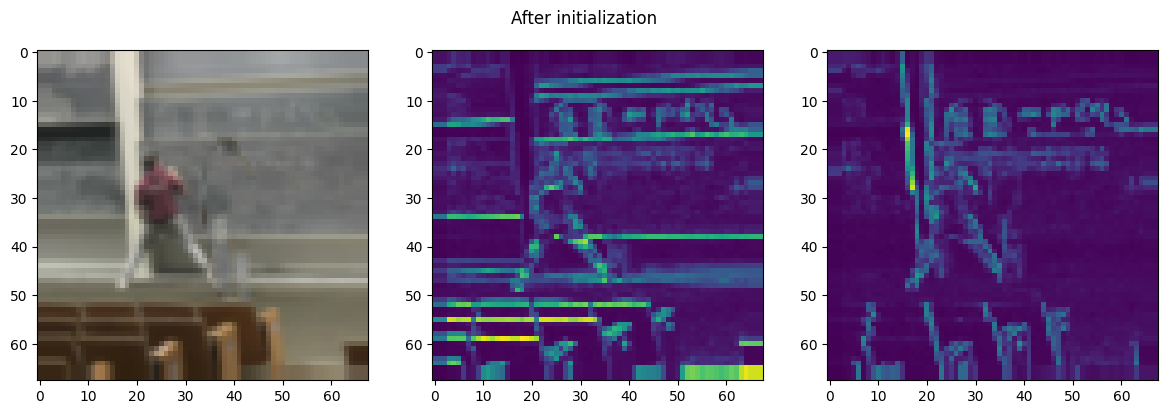

In [243]:
# Inpainting initialization with onion peel
structure_element = np.ones((PATCH_SIZE, PATCH_SIZE))
cross = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])
# original_coarse_mask = mask_pyramid[-1].copy()

coarse_mask = mask_pyramid[-1].copy()
dilated_coarse_mask = ndimage.binary_dilation(coarse_mask, structure=structure_element)
eroded_mask = ndimage.binary_erosion(dilated_coarse_mask, structure=cross)
boundary_mask = dilated_coarse_mask ^ eroded_mask

plt.imshow(boundary_mask); plt.show()

coarse_texture = texture_pyramid[-1].copy()
coarse_image = image_pyramid[-1].copy()

level_height, level_width, _ = coarse_image.shape

shift_map = np.zeros(shape=(level_height, level_width, 2), dtype=np.int64)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Before initialization")
ax[0].imshow(coarse_image)
ax[1].imshow(coarse_texture[...,1])
ax[2].imshow(coarse_texture[...,0])

plt.tight_layout()
plt.show()

for r in range(HALF_SIZE, level_height - HALF_SIZE):
    for c in range(HALF_SIZE, level_width - HALF_SIZE):
        # break_all = False

        # if boundary_mask[r, c]:
        #     for dr in range(-1, 2):
        #         for dc in range(-1, 2):
        #             if not in_bounds(r + dr, c + dc, level_height, level_width, dilated=True): continue
        #             if dilated_coarse_mask[r + dr, c + dc]: continue

        #             shift_map[r, c] = [dr, dc]
        #             break_all = True

        #             break
        #         if break_all: break

        # if break_all: continue

        random_i, random_j = r, c

        while dilated_coarse_mask[random_i, random_j]:
            random_i, random_j = np.random.randint(HALF_SIZE, level_height - HALF_SIZE), np.random.randint(HALF_SIZE, level_width - HALF_SIZE)
        
        shift_i, shift_j = random_i - r, random_j - c
        shift_map[r, c] = [shift_i, shift_j]

shrinking_mask = dilated_coarse_mask.copy()


def outline_patch(image, point1, point2, patch_size, mask=None):
    image_copy = image.copy()
    half_size = (patch_size + 2) // 2
    red_transparent = [255, 0, 0]

    # If a mask is provided, make everywhere in the image where the mask is true = black
    if mask is not None:
        image_copy[mask] = [0, 0, 0]

    image_copy[point1[0], point1[1]] = [255, 0, 0]
    image_copy[point2[0], point2[1]] = [0, 0, 255]

    # fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # for idx, point in enumerate([point1, point2]):
    #     r, c = point
    #     image_copy[r-half_size:r+half_size+1, c-half_size] = red_transparent
    #     image_copy[r-half_size:r+half_size+1, c+half_size] = red_transparent
    #     image_copy[r-half_size, c-half_size:c+half_size+1] = red_transparent
    #     image_copy[r+half_size, c-half_size:c+half_size+1] = red_transparent
    
    fig = plt.figure(figsize=(4, 5))
    gs = fig.add_gridspec(3,2)

    ax1 = fig.add_subplot(gs[0:2, :]); ax1.axis('off')
    ax2 = fig.add_subplot(gs[2, 0]); ax2.axis('off')
    ax3 = fig.add_subplot(gs[2, 1]); ax3.axis('off')

    ax1.imshow(image_copy)
    ax2.imshow(image[PATCH_REGION(*point1)])
    ax3.imshow(image[PATCH_REGION(*point2)])

    plt.tight_layout()
    plt.show()

lvl = 0
while shrinking_mask.any():
    eroded_mask = ndimage.binary_erosion(shrinking_mask, structure=cross)
    boundary_mask = shrinking_mask ^ eroded_mask

    distance_map = ann(coarse_image, coarse_texture, coarse_mask,
        shift_map=shift_map,
        init=True,
        boundary_mask=boundary_mask,
        shrinking_mask=shrinking_mask)

    if lvl >= HALF_SIZE:    
        reconstruction(coarse_image, coarse_texture, coarse_mask,
                    shift_map=shift_map,
                    distance_map=distance_map,
                    init=True,
                    boundary_mask=boundary_mask,
                    shrinking_mask=shrinking_mask)
    
    shrinking_mask = eroded_mask
    lvl += 1

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("After initialization")
ax[0].imshow(coarse_image)
ax[1].imshow(coarse_texture[...,1])
ax[2].imshow(coarse_texture[...,0])

plt.tight_layout()
plt.show()

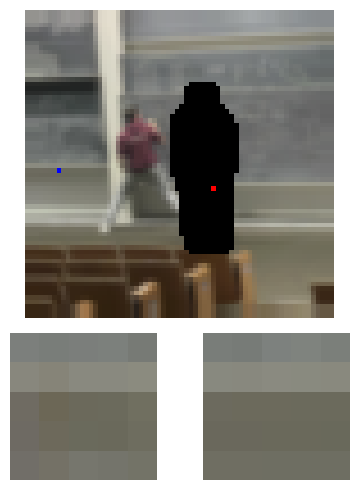

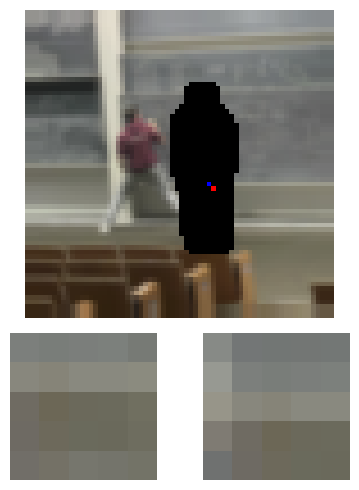

d1: nan,   d2: nan


/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_95602/3314599766.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/partial_patch_area * (ssd_image + lam * ssd_texture)
/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_95602/3314599766.py:32: RuntimeWarning: invalid value encountered in scalar multiply
  return 1/partial_patch_area * (ssd_image + lam * ssd_texture)


In [244]:
coord = np.array([39, 41])
matched_coord = coord + shift_map[coord[0], coord[1]]
my_coord = (coord[0]-1, coord[1]-1)

outline_patch(coarse_image, coord, matched_coord, PATCH_SIZE, mask=dilated_coarse_mask)
outline_patch(coarse_image, coord, my_coord, PATCH_SIZE, mask=dilated_coarse_mask)

d1 = partial_dist(coarse_image, coarse_texture, coarse_mask, coord, matched_coord)
d2 = partial_dist(coarse_image, coarse_texture, coarse_mask, coord, my_coord)

print(f"d1: {d1},   d2: {d2}")

Beginning level 3.................
   Level = 3, k = 1, e = 116.62485
   Level = 3, k = 2, e = 83.63346
   Level = 3, k = 3, e = 66.61870
   Level = 3, k = 4, e = 73.07626
   Level = 3, k = 5, e = 28.06642
   Level = 3, k = 6, e = 19.46617
   Level = 3, k = 7, e = 17.91636
   Level = 3, k = 8, e = 26.97048
   Level = 3, k = 9, e = 14.32595
   Level = 3, k = 10, e = 17.28290


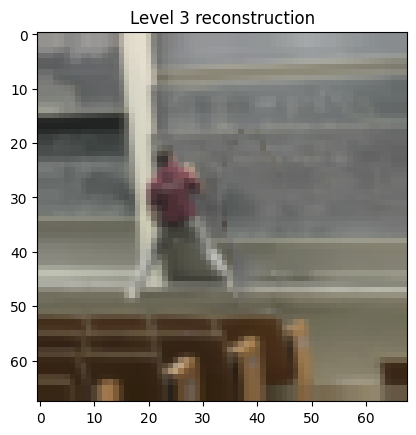

Beginning level 2.................
   Level = 2, k = 1, e = 103.10075
   Level = 2, k = 2, e = 70.93723
   Level = 2, k = 3, e = 47.77778
   Level = 2, k = 4, e = 45.85876
   Level = 2, k = 5, e = 29.77966
   Level = 2, k = 6, e = 36.28123
   Level = 2, k = 7, e = 38.26679
   Level = 2, k = 8, e = 30.72348
   Level = 2, k = 9, e = 27.46673
   Level = 2, k = 10, e = 28.55681


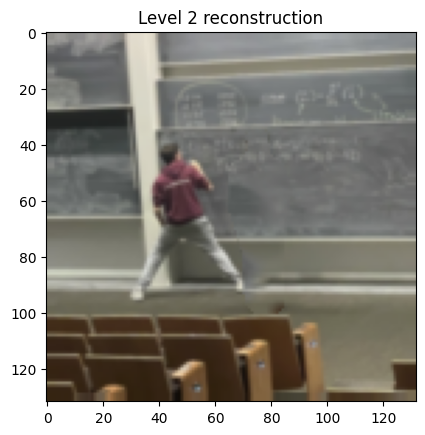

Beginning level 1.................
   Level = 1, k = 1, e = 85.80262
   Level = 1, k = 2, e = 57.83733
   Level = 1, k = 3, e = 52.47947
   Level = 1, k = 4, e = 42.90636
   Level = 1, k = 5, e = 37.36750
   Level = 1, k = 6, e = 36.33325
   Level = 1, k = 7, e = 31.83310
   Level = 1, k = 8, e = 29.75505
   Level = 1, k = 9, e = 28.23844
   Level = 1, k = 10, e = 23.88286


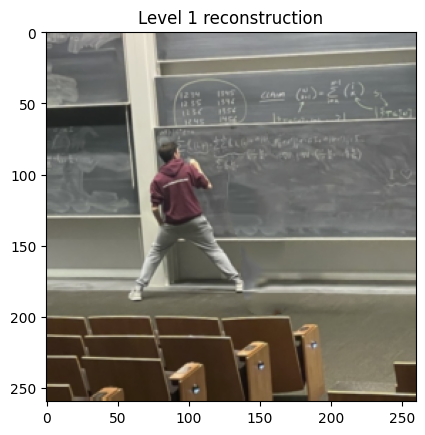

Beginning level 0.................
   Level = 0, k = 1, e = 77.50104
   Level = 0, k = 2, e = 54.52638
   Level = 0, k = 3, e = 43.27356
   Level = 0, k = 4, e = 38.25599
   Level = 0, k = 5, e = 33.86175
   Level = 0, k = 6, e = 31.62730
   Level = 0, k = 7, e = 27.93729
   Level = 0, k = 8, e = 27.21360
   Level = 0, k = 9, e = 27.31517
   Level = 0, k = 10, e = 26.02720


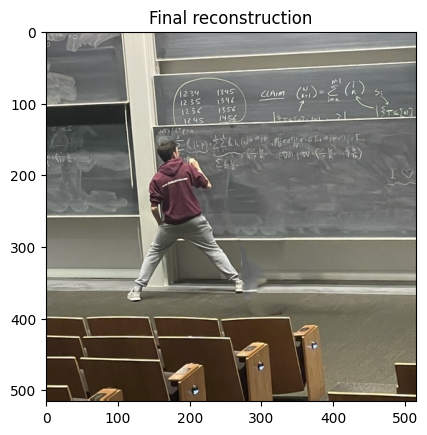

In [245]:
curr_image = coarse_image
curr_texture = coarse_texture
curr_mask = coarse_mask
curr_shift_map = shift_map

for l in range(n_pyramid_levels-1, -1, -1):
    print(f"Beginning level {l}.................")
    k = 0
    e = 1

    while e > 0.15 and k < 10:        
        v = curr_image.copy()
        distance_map = ann(curr_image, curr_texture, curr_mask,
                           shift_map=shift_map)
        reconstruction(curr_image, curr_texture, curr_mask,
                       shift_map=shift_map,
                       distance_map=distance_map)

        curr_hole_size = np.sum(curr_mask)

        masked_previous_image = v * curr_mask[:, :, np.newaxis]
        masked_updated_image = curr_image * curr_mask[:, :, np.newaxis]

        e = 1/(3*curr_hole_size) * np.sum(np.abs(masked_updated_image - masked_previous_image))
        k += 1

        print(f"   Level = {l}, k = {k}, e = {e:.5f}")

    if l == 0:
        plt.imshow(curr_image)
        plt.title(f"Final reconstruction")
        plt.show()
        
        final_image_reconstruction(curr_image, curr_mask,
                                   shift_map=shift_map,
                                   distance_map=distance_map)
    else:
        plt.imshow(curr_image)
        plt.title(f"Level {l} reconstruction")
        plt.show()
        
        upsampled_image = image_pyramid[l - 1]
        upsampled_texture = texture_pyramid[l - 1]
        upsampled_mask = mask_pyramid[l - 1]

        upsampled_shift_map = upsample_shift_map(shift_map)
        upsampled_distance_map = upsample_distance_map(upsampled_image, upsampled_texture, upsampled_mask, upsampled_shift_map)

        reconstruction(upsampled_image, upsampled_texture, upsampled_mask,
                    shift_map=upsampled_shift_map,
                    distance_map=upsampled_distance_map)
        
        curr_image = upsampled_image
        curr_texture = upsampled_texture
        curr_mask = upsampled_mask
        shift_map = upsampled_shift_map


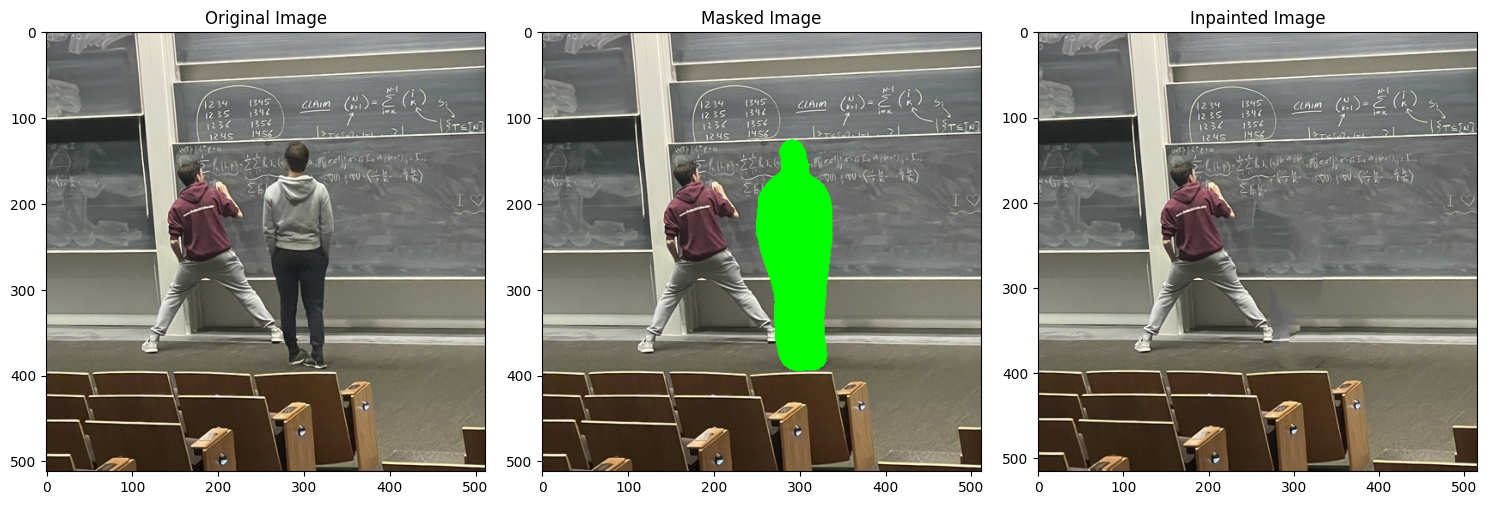

In [249]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(masked_image(image, mask))
ax[1].set_title("Masked Image")
ax[2].imshow(curr_image)
ax[2].set_title("Inpainted Image")

plt.tight_layout()
plt.savefig("menmax-done.png")
plt.show()
